<a href="https://colab.research.google.com/github/Osbird/MachineLearningForKnowledgeService_KnowledgeEngineering/blob/master/MachineLearningForKnowledgeService/%5Bhw1%5D20186484%3B_Polynomial_Approximation_by_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KSE 801, Homework 01

In [0]:
%pylab inline
import torch
import torch.nn as nn
import torch.utils.data
import torchvision

import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [0]:
POLY_DEGREE = 4
torch.manual_seed(0)
W_target = torch.randn(POLY_DEGREE, 1) * 5
b_target = torch.randn(1) * 5

In [0]:
def poly_desc(W, b):
    """Creates a string description of a polynomial."""
    result = 'y = '
    for i, w in enumerate(W):
        result += '{:+.2f} x^{} '.format(w, len(W) - i)
    result += '{:+.2f}'.format(b[0])
    return result

In [0]:
print('==> The real function you should approximate:\t' + poly_desc(W_target.view(-1), b_target))

==> The real function you should approximate:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


---

In [0]:
def make_features(x):
    """Builds features i.e. a matrix with columns [x^4, x^3, x^2, x^1]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** (POLY_DEGREE+1-i) for i in range(1, POLY_DEGREE+1)], 1)

In [0]:
def f(x):
    """Approximated function."""
    return x.mm(W_target) + b_target[0]

In [0]:
def get_dataset(dataset_size):
    """Builds a batch i.e. (x, f(x)) pair."""
    random = torch.randn(dataset_size)
    x = make_features(random)
    y = f(x)
    dataset = list(zip(x, y))
    return dataset

In [0]:
dataset = get_dataset(200) # you can make as many as dataset as you want

---

In [0]:
num_epochs = 500
batch_size = 50
learning_rate = 0.01
criterion = nn.SmoothL1Loss()

In [0]:
dataset_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

---

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(W_target.size(0), 1)
        
        # For fixing the initial weights and bias
        self.fc.weight.data.fill_(0.)
        self.fc.bias.data.fill_(0.)
        
    def forward(self, x):
        output = self.fc(x)
        return output

---

In [0]:


def fit(model,loader,criterion,learning_rate,num_epochs):
    '''
    fit function trains the model on data given by dataloader, according to given criterion 
    function returns array of losses averaged per epoch of training the model
    '''
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    lossArrayAllEpochs = []
    n=1
    for epoch in range(num_epochs):
        
        lossArrayWithinEpoch = []
        
        if n%100==0:
            '''            
            Add functionality for plotting function per 100th epoch
            '''
            print(str(n) + 'th epoch ==> Learned function:\t' + poly_desc(model.fc.weight.data.view(-1), model.fc.bias.data))
            print(str(n) + 'th epoch ==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))
            
            learnedModelWeights = (net.fc.weight.data).numpy()[0]
            learnedModelBias = (net.fc.bias.data.numpy())[0]
            
            actualModelWeights = W_target.view(-1).numpy()
            actualModelBias = b_target.numpy()[0]

            x = np.linspace(-1.2,1.2,200)
            plt.plot(x, PolyCoefficients(x, learnedModelWeights, learnedModelBias), 'r')
            plt.plot(x, PolyCoefficients(x, actualModelWeights, actualModelBias), 'g')
            plt.legend(['Learned Model', 'Actual Model'], loc='upper left')

            plt.show()
            print("--------------------------------- Separator Line ---------------------------------")
        
        for i, data in enumerate(loader):
            if torch.cuda.is_available(): # this condition is about gpu availability
                x = data[0].type(torch.FloatTensor).cuda()
                y = data[1].type(torch.FloatTensor).cuda()
            else:
                x = data[0].type(torch.FloatTensor)
                y = data[1].type(torch.FloatTensor)   
                
            y_hat = model(x)
            loss = criterion(y_hat, y)
            lossArrayWithinEpoch.append(loss.item()) #Add each loss withing epoch
            
            optimizer.zero_grad() # set gradient as 0
            loss.backward() # backpropagation
            optimizer.step() # update parameters (weights & bias)
        
        '''
        Calculation of average loss per epoch
        '''
        lossArrayAllEpochs.append(sum(lossArrayWithinEpoch)/len(lossArrayWithinEpoch))
        n+=1
        
    return lossArrayAllEpochs

---

In [0]:
net = Net().cuda() if torch.cuda.is_available() else Net()
print('==> Initial function:\t' + poly_desc(net.fc.weight.data.view(-1), net.fc.bias.data))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))


==> Initial function:	y = +0.00 x^4 +0.00 x^3 +0.00 x^2 +0.00 x^1 +0.00
==> Actual function:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


In [0]:
def PolyCoefficients(x, coeffs, bias):
    ''' 
    Returns a polynomial for ``x`` values for the ``coeffs`` provided, summed with the bias
    The coefficients must be in descending order (``x**o`` to ``x**0``).
    '''
    o = len(coeffs)
    y = bias
    for i in range(o):
        y += coeffs[i]*x**(o-i)
    return y

100th epoch ==> Learned function:	y = +5.51 x^4 +0.68 x^3 -0.62 x^2 +0.10 x^1 -3.37
100th epoch ==> Actual function:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


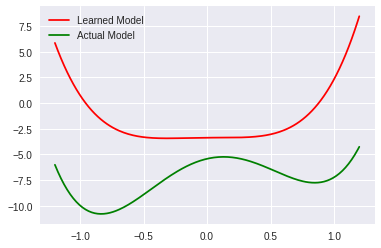

--------------------------------- Separator Line ---------------------------------
200th epoch ==> Learned function:	y = +5.98 x^4 +0.39 x^3 -2.40 x^2 +0.19 x^1 -6.24
200th epoch ==> Actual function:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


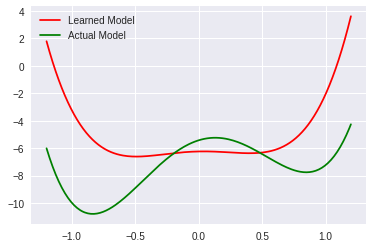

--------------------------------- Separator Line ---------------------------------
300th epoch ==> Learned function:	y = +6.34 x^4 +0.02 x^3 -3.99 x^2 +0.52 x^1 -6.96
300th epoch ==> Actual function:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


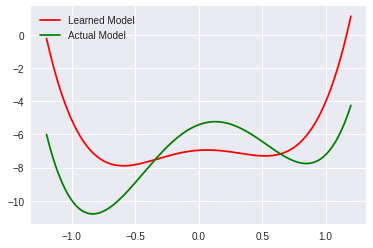

--------------------------------- Separator Line ---------------------------------
400th epoch ==> Learned function:	y = +6.65 x^4 -0.29 x^3 -5.45 x^2 +0.92 x^1 -7.04
400th epoch ==> Actual function:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


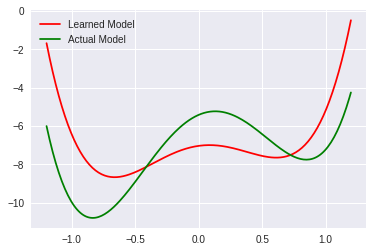

--------------------------------- Separator Line ---------------------------------
500th epoch ==> Learned function:	y = +6.93 x^4 -0.58 x^3 -6.82 x^2 +1.34 x^1 -6.82
500th epoch ==> Actual function:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


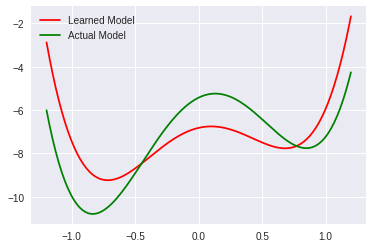

--------------------------------- Separator Line ---------------------------------


In [0]:
# train
losses = fit(net,dataset_loader,criterion,learning_rate,num_epochs)

In [0]:
print('==> Learned function:\t' + poly_desc(net.fc.weight.data.view(-1), net.fc.bias.data))
print('==> Actual function:\t' + poly_desc(W_target.view(-1), b_target))

==> Learned function:	y = +6.91 x^4 -0.59 x^3 -6.83 x^2 +1.34 x^1 -6.82
==> Actual function:	y = +7.70 x^4 -1.47 x^3 -10.89 x^2 +2.84 x^1 -5.42


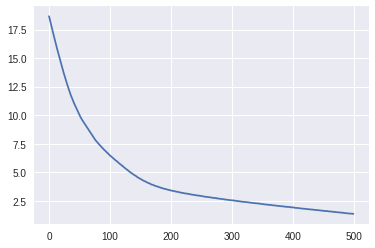

In [0]:
plot(losses) #Plot of loss per epoch, averaged within each epoch